In [1]:
from mesa import Agent, Model
from mesa.time import BaseScheduler
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

import random
import numpy as np
import matplotlib.pyplot as plt

state = {
        1: 'asymptomatic', 
        2: 'symptomatic', 
        3: 'critical', 
        4: 'cured', 
        5: 'deceased', 
        6: 'uninfected'
    }

grocery_stores = [(0, 251), (0, 252), (0, 253), (0, 254), (0, 255)]
parks = [(0, 256), (0, 257)]
quarantine_center = (0, 258)
deceased_people = (0, 259)

class SocietyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.status = state[6]
        self.infected = 0
        self.moved = 0
        self.original_pos = (0, 0)
    
    # Move agent to new positions: grocery stores/parks based on probability
    def move(self):
        places = ['park', 'grocery', 'home']
        # If person is at home, go to either park or grocery store
        if self.moved == 0:
            move_val = np.random.choice(places, p=[0.1, 0.2, 0.7])
            if move_val == 'park':
                new_pos = self.random.choice(parks)
                self.model.grid.move_agent(self, new_pos)
                self.moved = 1
            elif move_val == 'grocery':
                new_pos = self.random.choice(grocery_stores)
                self.model.grid.move_agent(self, new_pos)
                self.moved = 1
        # If person is at park or grocery store, move back home
        elif self.moved == 1:
            self.model.grid.move_agent(self, self.original_pos)
            self.moved = 0
        
    # Going from one infected to another based on the probability
    def change_status(self, agent):
        if agent.status == 'uninfected':
            # Changing probability when social distancing is considered
            if self.model.society_type == 'social_distancing':
                prob = [0.1, 0.9]
            else:
                prob = [0.5, 0.5]
            agent.status = np.random.choice(['asymptomatic', 'uninfected'], p=prob)
            if agent.status == 'asymptomatic':
                agent.infected = 1
        elif agent.status == 'asymptomatic':
            agent.status = np.random.choice(['symptomatic', 'asymptomatic'], p=[0.25, 0.75])
        elif agent.status == 'symptomatic':
            agent.status = np.random.choice(['critical', 'cured', 'symptomatic'], p=[0.1, 0.15, 0.75])
            if agent.status == 'cured':
                agent.infected = 0
        elif agent.status == 'critical':
            agent.status = np.random.choice(['cured', 'deceased', 'critical'], p=[0.2, 0.05, 0.75])
            if agent.status == 'cured' or agent.status == 'deceased':
                agent.infected = 0
    
    # Spreading infection
    def infect(self, st):
        # Infect everyone in infected person's cell with a probability
        cellmates = self.model.grid.get_cell_list_contents(self.pos)
        if 1 in [c.infected for c in cellmates]:
            self.change_status(self)

        
        # Move people to quarantine centers
        if st == 'quarantine' or st == 'social_distancing':
            quarantine_people = self.model.grid.get_cell_list_contents(quarantine_center)
            if self.status == 'symptomatic':
                x = np.random.choice(['quarantine_center', 'no_quarantine'], p=[0.2, 0.8])
                if x == 'quarantine_center' and len(quarantine_people) < 100:
                    self.model.grid.move_agent(self, quarantine_center)
            elif self.status == 'critical' and len(quarantine_people) < 100:
                self.model.grid.move_agent(self, quarantine_center)
            self.moved = 2
            
            # If the person is cured or dead, then move person out of the quarantine center
            for q in quarantine_people:
                # If the person is cured, move to home
                if q.status == 'cured':
                    self.model.grid.move_agent(self, q.original_pos)
                    self.moved = 0
                # If the person is dead, move to deceased people cell
                elif q.status == 'deceased':
                    self.model.grid.move_agent(self, deceased_people)
                    self.moved = 0
                

    def step(self):
        self.move()
        self.infect(self.model.society_type)



In [2]:
class SocietyModel(Model):
    
    def __init__(self, N, width, height, initial, society_type):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = BaseScheduler(self)
        self.society_type = society_type

        y = 0
        # Create agents
        for i in range(self.num_agents):
            a = SocietyAgent(i, self)
            self.schedule.add(a)

            # Assign 4 people to one house
            self.grid.place_agent(a, (0, y))
            a.original_pos = a.pos
            if len(self.grid.get_cell_list_contents((0, y))) == 4:
                    y += 1
                    
    # Randomly infect initial people
        for i in range(int(initial*self.num_agents)):
            a = random.choice(self.schedule.agents)
            while a.status == state[1]:
                a = random.choice(self.schedule.agents)
            a.status = state[1]
            a.infected = 1

    # Get the number of infections and the number of people in each state
    def get_infections(self):
        dict = {'cured': 0, 'deceased': 0, 'uninfected': 0, 'asymptomatic': 0, 'symptomatic': 0, 'critical': 0}
        infections = 0
        for i in self.schedule.agents:
            infections += i.infected
            dict[i.status] += 1
        return infections, dict

    def step(self):
        self.schedule.step()

In [3]:
# Plotting graphs with 
def visualize(initial, society_type):
    avg_days, avg_cured, avg_dead, avg_uninfected = 0, 0, 0, 0
    # Running the model to consider average values to reduce randomness
    for x in range(20):
        model = SocietyModel(1000, 1, 260, initial, society_type)
        days = 0
        total, infections, cured, dead, q = [], [], [], [], []
        i = 1
        while i:
            total.append(days)
            i, d = model.get_infections()
            infections.append(i)
            cured.append(d['cured'])
            dead.append(d['deceased'])
            q.append(len(model.grid.get_cell_list_contents(quarantine_center)))
            days += 1
            model.step()

        # Calculating averages
        avg_days += days
        avg_cured += d['cured']
        avg_dead += d['deceased']
        avg_uninfected += d['uninfected']
    avg_days, avg_cured, avg_dead, avg_uninfected = avg_days // 20, avg_cured // 20, avg_dead // 20, avg_uninfected // 20

    print("Number of days: " + str(avg_days))
    print("Cured: " + str(avg_cured))
    print("Dead: " + str(avg_dead))
    print("Uninfected: " + str(avg_uninfected))

    # Plotting graphs
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(total, infections)
    plt.bar(total, infections)
    plt.xlabel('Days')
    plt.ylabel('Number of infections')
    
    plt.subplot(122)
    plt.plot(total, infections, 'blue', total, cured, 'green', total, dead, 'red', total, q, 'yellow')
    plt.xlabel('Days')
    plt.ylabel('Number of infections')
    plt.gca().legend(['infections', 'cured', 'deceased', 'quarantine center'])
    plt.show()

*****WITHOUT QUARANTINE OR SOCIAL DISTANCING*****


With 10% initial infections:

Number of days: 47
Cured: 919
Dead: 80
Uninfected: 0


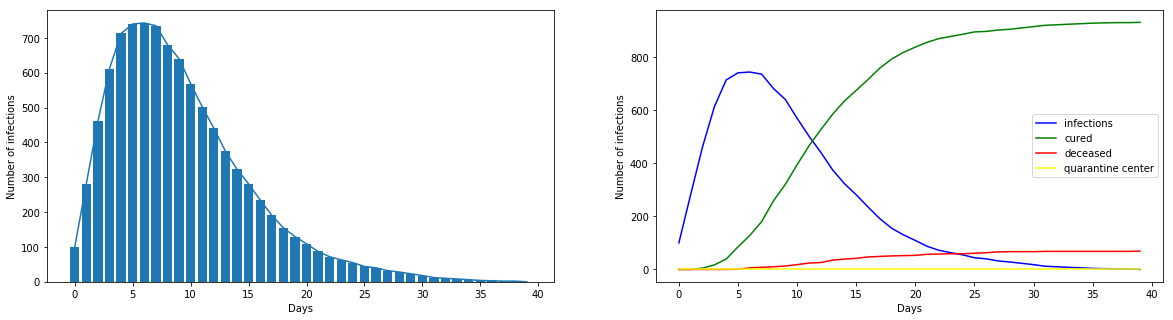

With 25% initial infections:

Number of days: 46
Cured: 923
Dead: 76
Uninfected: 0


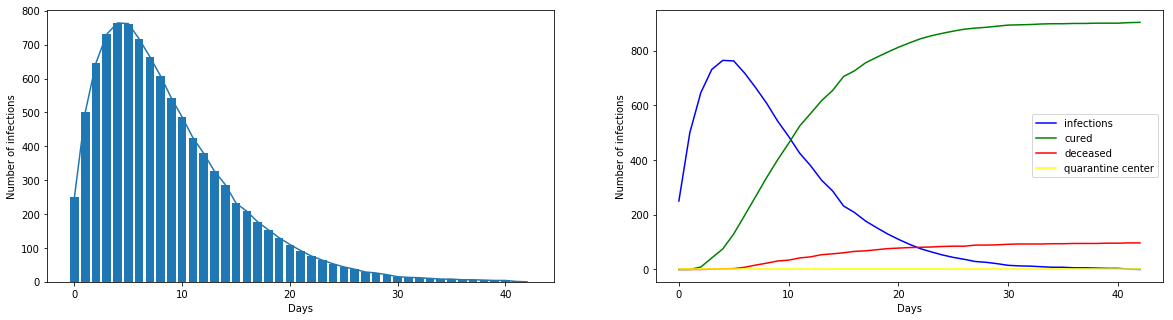

With 50% initial infections:

Number of days: 42
Cured: 918
Dead: 81
Uninfected: 0


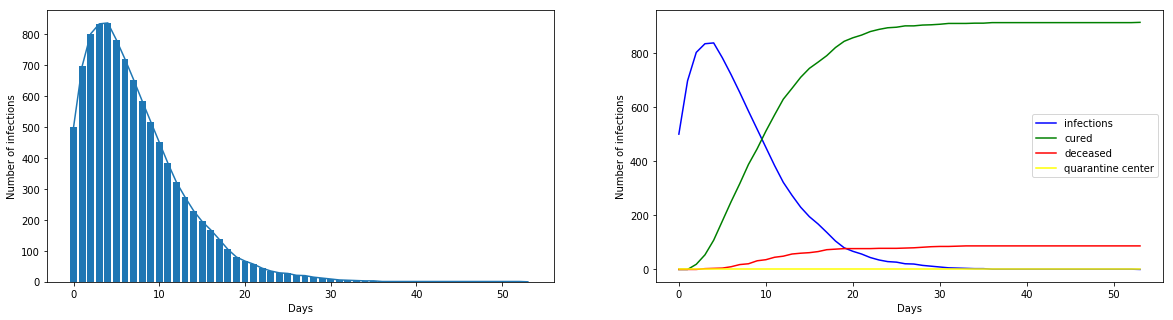

In [4]:
print("*****WITHOUT QUARANTINE OR SOCIAL DISTANCING*****\n\n")

print("With 10% initial infections:\n")
visualize(0.1, '')
print("With 25% initial infections:\n")
visualize(0.25, '')
print("With 50% initial infections:\n")
visualize(0.5, '')

*****WITH QUARANTINE, WITHOUT SOCIAL DISTANCING*****


With 10% initial infections:

Number of days: 39
Cured: 460
Dead: 40
Uninfected: 498


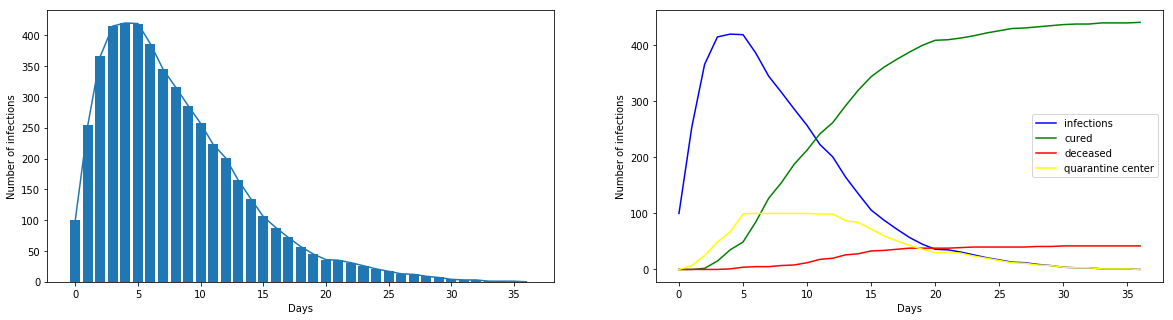

With 25% initial infections:

Number of days: 43
Cured: 660
Dead: 59
Uninfected: 279


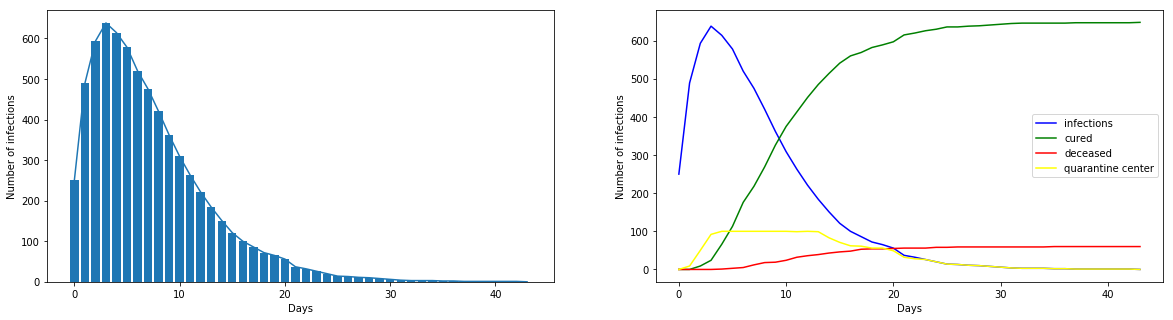

With 50% initial infections:

Number of days: 42
Cured: 839
Dead: 76
Uninfected: 83


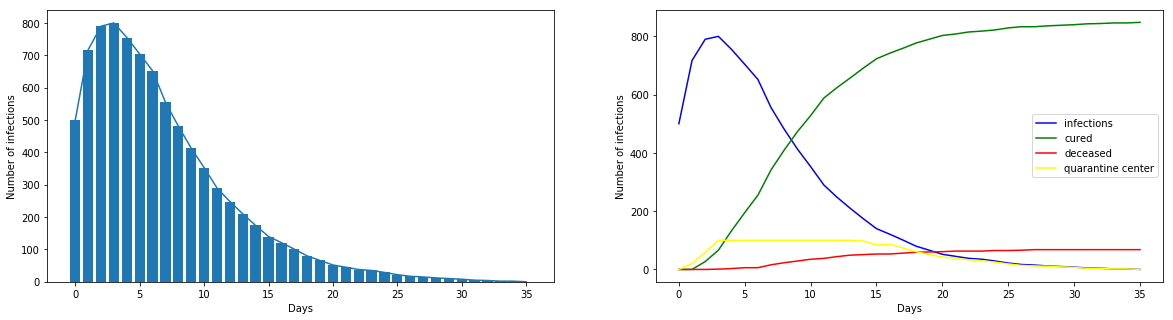

In [5]:
print("*****WITH QUARANTINE, WITHOUT SOCIAL DISTANCING*****\n\n")

print("With 10% initial infections:\n")
visualize(0.1, 'quarantine')
print("With 25% initial infections:\n")
visualize(0.25, 'quarantine')
print("With 50% initial infections:\n")
visualize(0.5, 'quarantine')

*****WITH QUARANTINE AND SOCIAL DISTANCING*****


With 10% initial infections:

Number of days: 55
Cured: 387
Dead: 33
Uninfected: 579


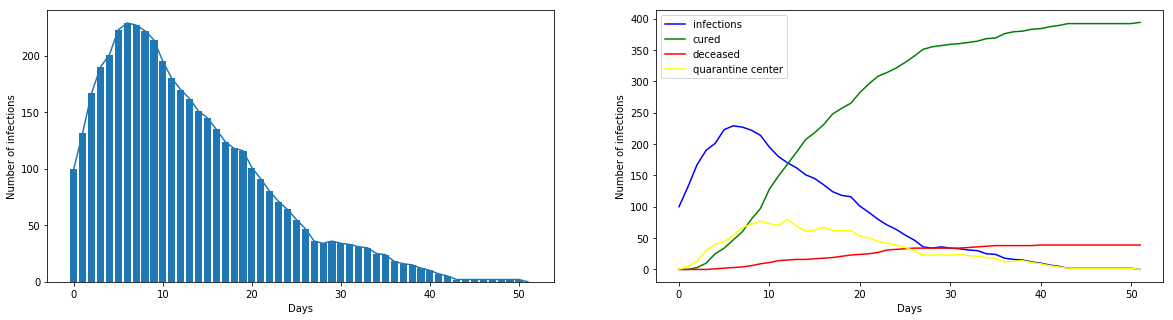

With 25% initial infections:

Number of days: 50
Cured: 538
Dead: 45
Uninfected: 416


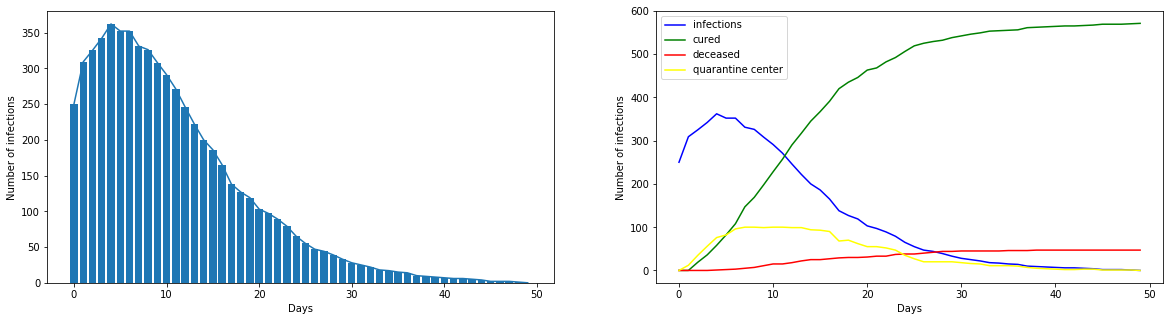

With 50% initial infections:

Number of days: 50
Cured: 717
Dead: 63
Uninfected: 219


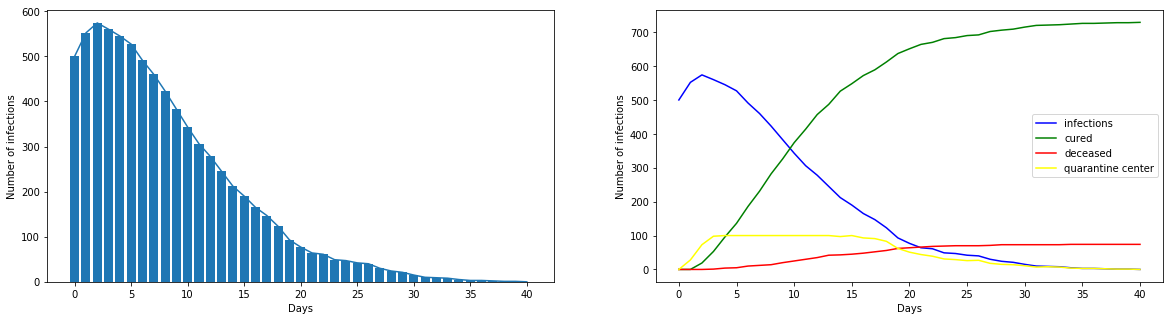

In [6]:
print("*****WITH QUARANTINE AND SOCIAL DISTANCING*****\n\n")

print("With 10% initial infections:\n")
visualize(0.1, 'social_distancing')
print("With 25% initial infections:\n")
visualize(0.25, 'social_distancing')
print("With 50% initial infections:\n")
visualize(0.5, 'social_distancing')